In [347]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

In [348]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None, oldDataset=False):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.images = os.listdir(root_dir)
        self.oldDataset = oldDataset
        self.deliminator = '_'  # Default to deliminator for new dataset

        # Extract labels from image filenames
        self.name_labels = [self._get_label(img_name) for img_name in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        label = self.name_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def _get_label(self, img_name):
        return img_name.lower().split(self.deliminator)[0]
    

In [349]:
classes = ['ford', 'toyota', 'chevrolet', 'bmw', 'nissan', 'audi']
image_width = 128

# Convert images into tensors
transform = transforms.Compose([
    transforms.Resize((image_width, image_width)),
    transforms.ToTensor(),
])

newDatasetRoot = './CarDataset'
oldDatasetRoot = './car-dataset-200'
combinedDatasetRoot = './combined-dataset'

In [350]:
oldset = False
combinedset = False
if combinedset:
    dataset = CustomDataset(root_dir=combinedDatasetRoot, classes=classes, transform=transform, oldDataset=False)
elif oldset:
    dataset = CustomDataset(root_dir=oldDatasetRoot, classes=classes, transform=transform, oldDataset=True)
else:
    dataset = CustomDataset(root_dir=newDatasetRoot, classes=classes, transform=transform, oldDataset=False)
    
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [351]:
print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  51573
Test size:  12894


In [352]:
batch_size = 4
if torch.cuda.is_available():
    device = torch.device('cuda')
    batch_size = 64
else:
    device = torch.device('cpu')
    batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [353]:
print(dataset.__len__())
print(len(dataset.name_labels))
print(len(dataset.images))
print(dataset.classes)

print(dataset.images[:6])
print(dataset.name_labels[:6])

64467
64467
64467
['ford', 'toyota', 'chevrolet', 'bmw', 'nissan', 'audi']
['BMW_3-Series_2020_40_18_250_20_4_71_56_185_26_RWD_5_4_4dr_xSE.jpg', 'Nissan_GT-R_2017_174_20_600_38_6_74_53_184_16_AWD_4_2_2dr_MQS.jpg', 'Rolls-Royce_Wraith_2015_294_20_620_66_12_76_59_207_13_RWD_4_2_2dr_wHC.jpg', 'Chevrolet_Cruze_2011_18_17_130_14_4_70_58_181_28_FWD_5_4_4dr_jNO.jpg', 'Lexus_RC_2015_45_18_300_35_6_72_55_184_19_AWD_4_2_2dr_dAe.jpg', 'Hyundai_Sonata_2011_27_18_270_20_4_72_57_189_22_FWD_5_4_4dr_YPg.jpg']
['bmw', 'nissan', 'rolls-royce', 'chevrolet', 'lexus', 'hyundai']


bmw 3
toyota 1
ford 0
chevrolet 2
nissan 4
audi 5


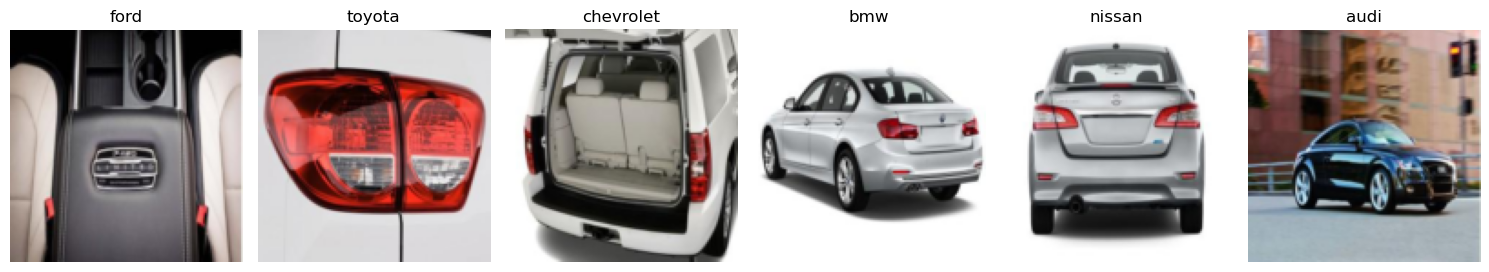

In [354]:
# Print example images from each class
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))
example_found = [False] * len(classes)
classesToIndex = {}
for i, c in enumerate(classes):
    classesToIndex[c] = i

for images, labels in train_loader:
    # images: a batch of images
    # labels: corresponding labels for the batch
    for i in range(images.size(0)):  # Iterate through the batch
        # label = dataset.label_encoder.inverse_transform([labels[i]])[0]
        label = labels[i]
        if label in classes and not example_found[classesToIndex[label]]:
            print(label, classesToIndex[label])
            img = images[i]  # Get the image tensor
            img = transforms.ToPILImage()(img)  # Convert to PIL Image for displaying
            axes[classesToIndex[label]].imshow(img)
            axes[classesToIndex[label]].set_title(label)
            axes[classesToIndex[label]].axis('off')
            example_found[classesToIndex[label]] = True
        if all(example_found):
            break
    if all(example_found):
        break

plt.tight_layout()
plt.show()

In [355]:
# Initialize a dictionary to count instances of each class
class_counts = defaultdict(int)

# Hold the selected indices for a balanced dataset
selected_indices = []
classCountsLimitOld = 2100
classCountsLimitNew = 3000

if combinedset:
    classCountsLimit = classCountsLimitOld + classCountsLimitNew
elif oldset:
    classCountsLimit = classCountsLimitOld
else:
    classCountsLimit = classCountsLimitNew

# Iterate over the train_dataset to count classes and select indices
for idx in range(len(dataset)):
    label = dataset.name_labels[idx]
    print(label) if idx < 10 else None
    if label in classes and class_counts[label] < classCountsLimit:
        selected_indices.append(idx)
        class_counts[label] += 1



bmw
nissan
rolls-royce
chevrolet
lexus
hyundai
lincoln
dodge
land rover
toyota


In [356]:
# Create the dataset from the selected indices
balanced_dataset = Subset(dataset, selected_indices)

In [357]:
# Encode the labels
labels_encoded = [classesToIndex[label] for label in dataset.name_labels if label in classes]
labels = torch.tensor(labels_encoded)

In [358]:
print(labels_encoded[:10])
print(labels[:10])

[3, 4, 2, 1, 0, 1, 0, 4, 3, 5]
tensor([3, 4, 2, 1, 0, 1, 0, 4, 3, 5])


In [359]:
balanced_train_dataset, balanced_test_dataset = random_split(balanced_dataset, [int(4*classCountsLimit/5)*len(classes), int(1*classCountsLimit/5)*len(classes)])
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, num_workers=4)
balanced_test_loader = DataLoader(balanced_test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [360]:
print("Balanced train size: ", len(balanced_train_dataset))
print("Balanced test size: ", len(balanced_test_dataset))

Balanced train size:  14400
Balanced test size:  3600


In [361]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # self.dropout2 = nn.Dropout(0.35)
        self.fc2 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 64 * 32 * 32)
        x = torch.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [362]:
# # Define neural net architecture
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.dropout1 = nn.Dropout(0.25)  # Between conv layers
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.dropout2 = nn.Dropout(0.25)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout3 = nn.Dropout(0.25)  # After pooling layers
#         self.fc1 = nn.Linear(128 * 32 * 32, 128)
#         self.dropout4 = nn.Dropout(0.5)  # Before the final layer
#         self.fc2 = nn.Linear(128, 6)  # 6 classes

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.dropout1(x)
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout2(x)
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.dropout3(x)  # Apply dropout after pooling
#         x = x.view(-1, 128 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = self.dropout4(x)  # Apply dropout before final layer
#         x = self.fc2(x)
#         return x

In [363]:
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)
print(device)

# Use optimizers and hyperparameters
criterion = nn.CrossEntropyLoss()
# weight_decay = 1e-5
weight_decay = 5e-5
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=weight_decay)

cuda


In [364]:
warnings.filterwarnings("ignore", category=UserWarning)
epochs = 15
train_losses = []
test_losses = []
print(f"number of train batches: {len(balanced_train_loader)}")
print(f"number of test batches: {len(balanced_test_loader)}")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in balanced_train_loader:
        labels_encoded = [classesToIndex[label] for label in labels if label in classes]
        labels = torch.tensor(labels_encoded)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        # No unsqueeze needed for batched input
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(balanced_train_loader))

    # Evaluate on testing set
    model.eval()
    test_loss = 0
    accuracy = 0
    # Count the number of samples
    total = 0
    with torch.no_grad():
        for inputs, labels in balanced_test_loader:
            labels_encoded = [classesToIndex[label] for label in labels if label in classes]
            labels = torch.tensor(labels_encoded)
            inputs, labels = inputs.to(device), labels.to(device)
            # No unsqueeze needed for batched input
            outputs = model(inputs)
            test_loss += criterion(outputs, labels)  # Do we need the .item()?
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(balanced_test_loader))
    accuracy = accuracy / total  # Should we divide by the running total or the total size of test_dataset?

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Training loss: {train_losses[-1]:.3f}.. "
          f"Test loss: {test_losses[-1]:.3f}.. "
          f"Test accuracy: {accuracy:.3f}")

number of train batches: 225
number of test batches: 57
Epoch 1/15.. Training loss: 1.746.. Test loss: 1.637.. Test accuracy: 0.335
Epoch 2/15.. Training loss: 1.479.. Test loss: 1.409.. Test accuracy: 0.463
Epoch 3/15.. Training loss: 1.148.. Test loss: 1.249.. Test accuracy: 0.547
Epoch 4/15.. Training loss: 0.832.. Test loss: 1.190.. Test accuracy: 0.590
Epoch 5/15.. Training loss: 0.572.. Test loss: 1.171.. Test accuracy: 0.629
Epoch 6/15.. Training loss: 0.359.. Test loss: 1.321.. Test accuracy: 0.647
Epoch 7/15.. Training loss: 0.216.. Test loss: 1.415.. Test accuracy: 0.651
Epoch 8/15.. Training loss: 0.141.. Test loss: 1.575.. Test accuracy: 0.662
Epoch 9/15.. Training loss: 0.096.. Test loss: 1.758.. Test accuracy: 0.653
Epoch 10/15.. Training loss: 0.071.. Test loss: 1.837.. Test accuracy: 0.657
Epoch 11/15.. Training loss: 0.056.. Test loss: 1.904.. Test accuracy: 0.670
Epoch 12/15.. Training loss: 0.051.. Test loss: 2.023.. Test accuracy: 0.662
Epoch 13/15.. Training loss: 

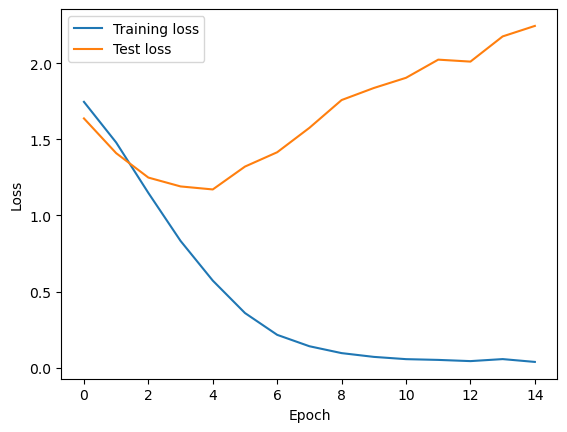

In [369]:
#test_losses = [loss.item() for loss in test_losses]
# Plotting training and testing losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [370]:
def show_predictions(model, dataset, num_images=10):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure to grab a batch of images from the DataLoader
    # data_loader = balanced_test_loader
    data_loader = torch.utils.data.DataLoader(balanced_test_dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))  # Get one batch of images and labels
    labels_encoded = [classesToIndex[label] for label in labels if label in classes]
    labels = torch.tensor(labels_encoded)
    
    with torch.no_grad():  # No need to track gradients for visualization
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        images = images.cpu()  # Move images back to CPU for visualization
        
        for i in range(num_images):
            img = images[i]  # No unsqueeze needed since we're iterating over the batch
            img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for plotting
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
            
            plt.figure(figsize=(2, 2))
            plt.imshow(img)
            plt.title(f'True: {classes[labels[i].item()]}, Pred: {classes[predictions[i].item()]}')
            plt.axis('off')
            plt.show()

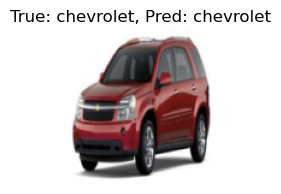

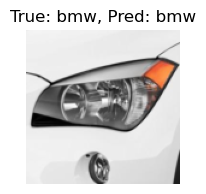

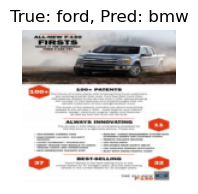

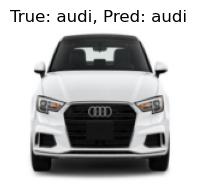

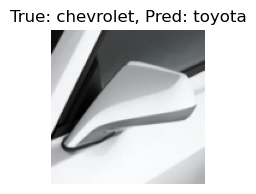

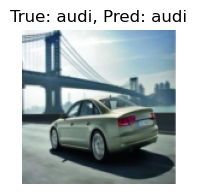

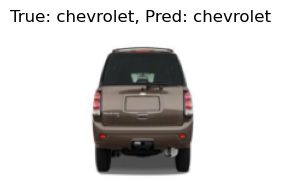

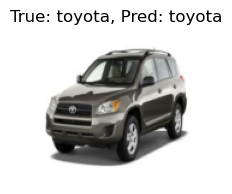

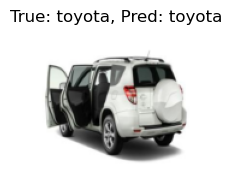

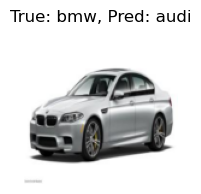

In [371]:
show_predictions(model, balanced_dataset, num_images=10)